In [1]:
!pip install SciencePlots --upgrade
!sudo apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 57.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd

import os, json # cv2 -- OpenCV
import shutil
import zipfile

import scienceplots

plt.style.use(['science','nature'])

%matplotlib inline

In [3]:
res_folder = '/content/drive/MyDrive/Research/Quanvolution/scripts/results'
res_files = [file for file in os.listdir(res_folder) if file.endswith('.json')]
print(res_files)

['20240430_072512_MNIST_replacement_lvl_0_rep_0.json', '20240430_072512_MNIST_replacement_lvl_0_rep_1.json', '20240430_072512_MNIST_replacement_lvl_0_rep_2.json', '20240430_072512_MNIST_replacement_lvl_0_rep_3.json', '20240430_072512_MNIST_replacement_lvl_0_rep_4.json', '20240430_072512_FashionMNIST_replacement_lvl_0_rep_0.json', '20240430_072512_FashionMNIST_replacement_lvl_0_rep_1.json', '20240430_072512_FashionMNIST_replacement_lvl_0_rep_2.json', '20240430_072512_FashionMNIST_replacement_lvl_0_rep_3.json', '20240430_072512_FashionMNIST_replacement_lvl_0_rep_4.json', '20240430_072512_CIFAR10_replacement_lvl_0_rep_0.json', '20240430_072512_CIFAR10_replacement_lvl_0_rep_1.json', '20240430_072512_CIFAR10_replacement_lvl_0_rep_2.json', '20240430_072512_CIFAR10_replacement_lvl_0_rep_3.json', '20240430_072512_CIFAR10_replacement_lvl_0_rep_4.json', '20240430_072512_MNIST_replacement_lvl_2_rep_0.json', '20240430_072512_MNIST_replacement_lvl_2_rep_1.json', '20240430_072512_MNIST_replacement_l

In [8]:
reps = [0,1,2,3,4]
replacement_lvls = [0,1,2]
datasets = ['MNIST', 'FashionMNIST', 'CIFAR10']
metrics = ['train_losses', 'train_accs', 'test_losses', 'test_accs']

def calculate_mean_std(dataset_name:str, replacement_lvl:int, res_folder:str):
  res_files_all = [file for file in os.listdir(res_folder) if file.endswith('.json')]
  res_files = [file for file in res_files_all if f"_{dataset_name}_" in file and f"replacement_lvl_{replacement_lvl}" in file]
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for file in res_files:
    with open(os.path.join(res_folder, file), 'r') as f:
      data = json.load(f)
    train_losses.append(data['train_losses'])
    train_accs.append(data['train_accs'])
    test_losses.append(data['test_losses'])
    test_accs.append(data['test_accs'])
  train_losses = np.array(train_losses)
  train_accs = np.array(train_accs)
  test_losses = np.array(test_losses)
  test_accs = np.array(test_accs)
  train_loss_avg = np.mean(train_losses, axis=0)
  train_acc_avg = np.mean(train_accs, axis=0)
  test_loss_avg = np.mean(test_losses, axis=0)
  test_acc_avg = np.mean(test_accs, axis=0)
  train_loss_std = np.std(train_losses, axis=0)
  train_acc_std = np.std(train_accs, axis=0)
  test_loss_std = np.std(test_losses, axis=0)
  test_acc_std = np.std(test_accs, axis=0)
  metrics_avg = {
      'train_losses': train_loss_avg,
      'train_accs': train_acc_avg,
      'test_losses': test_loss_avg,
      'test_accs': test_acc_avg
  }
  metrics_std = {
      'train_losses': train_loss_std,
      'train_accs': train_acc_std,
      'test_losses': test_loss_std,
      'test_accs': test_acc_std
  }
  return metrics_avg, metrics_std

processed_avg = {}
processed_std = {}

last_iter_avg = {}
last_iter_std = {}

first_iter_avg = {}
first_iter_std = {}

for dataset in datasets:
  processed_avg[dataset] = {}
  processed_std[dataset] = {}
  last_iter_avg[dataset] = {}
  last_iter_std[dataset] = {}
  first_iter_avg[dataset] = {}
  first_iter_std[dataset] = {}
  for replacement_lvl in replacement_lvls:
    metrics_avg, metrics_std = calculate_mean_std(dataset, replacement_lvl, res_folder)
    processed_avg[dataset][replacement_lvl] = metrics_avg
    processed_std[dataset][replacement_lvl] = metrics_std
    last_iter_avg[dataset][replacement_lvl] = {}
    last_iter_std[dataset][replacement_lvl] = {}
    first_iter_avg[dataset][replacement_lvl] = {}
    first_iter_std[dataset][replacement_lvl] = {}
    for metric in metrics:
      last_iter_avg[dataset][replacement_lvl][metric] = metrics_avg[metric][-1]
      last_iter_std[dataset][replacement_lvl][metric] = metrics_std[metric][-1]

      first_iter_avg[dataset][replacement_lvl][metric] = metrics_avg[metric][0]
      first_iter_std[dataset][replacement_lvl][metric] = metrics_std[metric][0]

laster_iter_avg_df = {dataset:pd.DataFrame(last_iter_avg[dataset]) for dataset in datasets}
laster_iter_std_df = {dataset:pd.DataFrame(last_iter_std[dataset]) for dataset in datasets}

first_iter_avg_df = {dataset:pd.DataFrame(first_iter_avg[dataset]) for dataset in datasets}
first_iter_std_df = {dataset:pd.DataFrame(first_iter_std[dataset]) for dataset in datasets}

last_iter_gen_error = {dataset:pd.DataFrame({'loss':laster_iter_avg_df[dataset].loc['test_losses']-laster_iter_avg_df[dataset].loc['train_losses'], 'acc':laster_iter_avg_df[dataset].loc['test_accs']-laster_iter_avg_df[dataset].loc['train_accs']}) for dataset in datasets}

In [11]:
first_iter_avg_df['MNIST']

,0,1,2
train_losses,0.410017,0.583465,0.486217
train_accs,0.881623,0.833267,0.843747
test_losses,0.297423,0.339109,0.200527
test_accs,0.915540,0.900520,0.937600


In [12]:
first_iter_avg_df['FashionMNIST']

,0,1,2
train_losses,0.524240,0.747951,0.700926
train_accs,0.818653,0.750710,0.749770
test_losses,0.476294,0.543421,0.548034
test_accs,0.834980,0.804820,0.804660


In [13]:
first_iter_avg_df['CIFAR10']

,0,1,2
train_losses,1.793432,2.268388,2.031689
train_accs,0.381572,0.246428,0.272300
test_losses,1.737392,2.031044,1.853133
test_accs,0.401760,0.289780,0.338620


In [14]:
last_iter_gen_error['MNIST']

,loss,acc
0,0.064848,-0.012093
1,0.068531,-0.012550
2,0.048716,-0.009050


In [15]:
last_iter_gen_error['FashionMNIST']

,loss,acc
0,0.125292,-0.039277
1,0.123884,-0.040907
2,0.124919,-0.035423


In [16]:
last_iter_gen_error['CIFAR10']

,loss,acc
0,0.392382,-0.119720
1,0.166457,-0.061420
2,0.202207,-0.061028


In [17]:
laster_iter_avg_df['MNIST']

,0,1,2
train_losses,0.229441,0.226684,0.076071
train_accs,0.935053,0.935930,0.978290
test_losses,0.294288,0.295216,0.124787
test_accs,0.922960,0.923380,0.969240


In [18]:
laster_iter_avg_df['FashionMNIST']

,0,1,2
train_losses,0.350305,0.352763,0.280170
train_accs,0.875497,0.874967,0.901163
test_losses,0.475597,0.476646,0.405089
test_accs,0.836220,0.834060,0.865740


In [19]:
laster_iter_avg_df['CIFAR10']

,0,1,2
train_losses,1.500389,1.613229,1.282986
train_accs,0.489520,0.449920,0.550408
test_losses,1.892771,1.779686,1.485193
test_accs,0.369800,0.388500,0.489380


In [20]:
laster_iter_std_df['MNIST']

,0,1,2
train_losses,0.000410,0.000425,0.005649
train_accs,0.000173,0.000413,0.001299
test_losses,0.001066,0.004375,0.015940
test_accs,0.001326,0.001292,0.003238


In [21]:
laster_iter_std_df['FashionMNIST']

,0,1,2
train_losses,0.000850,0.000368,0.003557
train_accs,0.000571,0.000216,0.000680
test_losses,0.001606,0.007311,0.019196
test_accs,0.001379,0.003690,0.006161


In [22]:
laster_iter_std_df['CIFAR10']

,0,1,2
train_losses,0.001380,0.004937,0.011760
train_accs,0.000978,0.001330,0.004930
test_losses,0.002114,0.002259,0.012507
test_accs,0.003064,0.002577,0.000866


MNIST train_losses


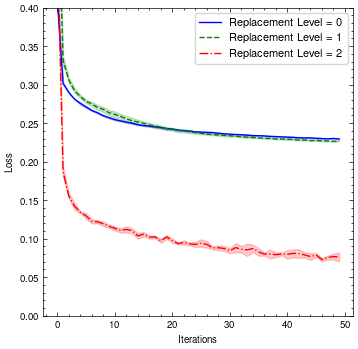

MNIST train_accs


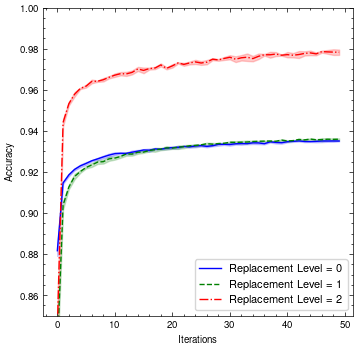

MNIST test_losses


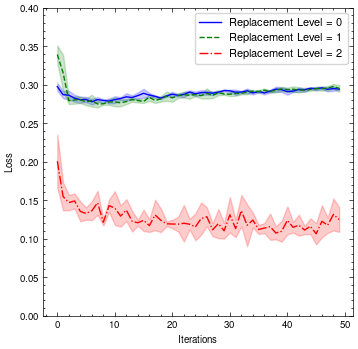

MNIST test_accs


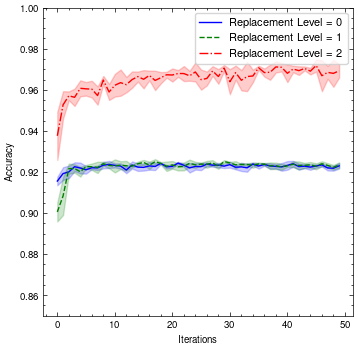

FashionMNIST train_losses


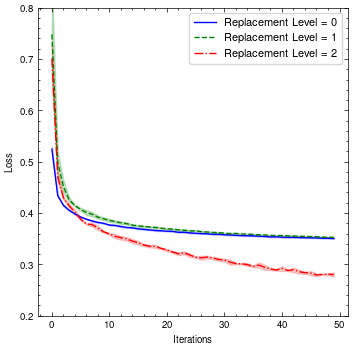

FashionMNIST train_accs


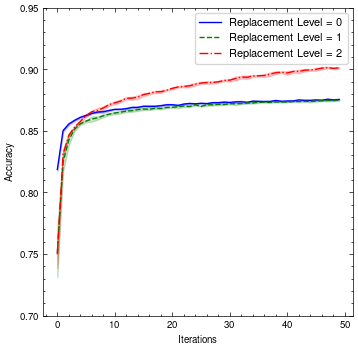

FashionMNIST test_losses


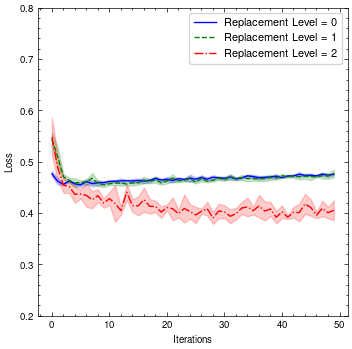

FashionMNIST test_accs


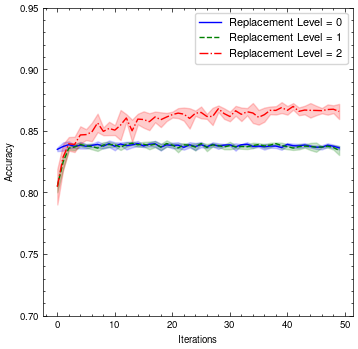

CIFAR10 train_losses


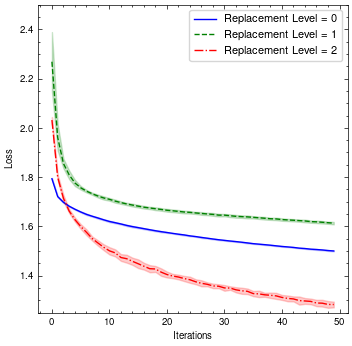

CIFAR10 train_accs


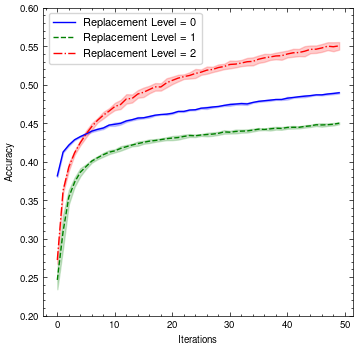

CIFAR10 test_losses


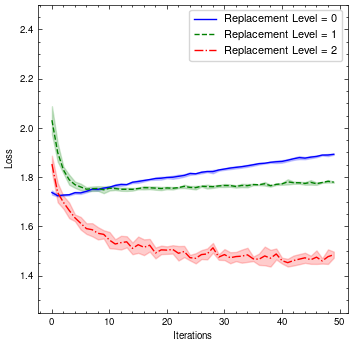

CIFAR10 test_accs


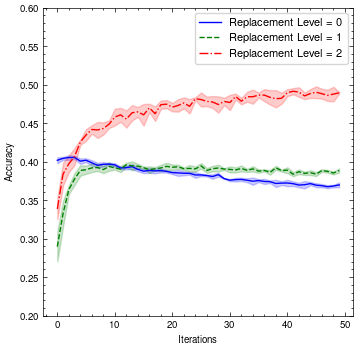

In [23]:
iters = np.arange(len(processed_avg['MNIST'][0]['train_losses']))
for dataset in datasets:
  for metric_name in metrics:
    print(dataset, metric_name)
    fig = plt.figure(figsize=(4, 4))
    plt.plot(iters, processed_avg[dataset][0][metric_name], label='Replacement Level = 0',color='blue', linestyle='-',)
    plt.plot(iters, processed_avg[dataset][1][metric_name], label='Replacement Level = 1',color='green', linestyle='--')
    plt.plot(iters, processed_avg[dataset][2][metric_name], label='Replacement Level = 2',color='red', linestyle='-.')
    # standard deviations
    plt.fill_between(iters, processed_avg[dataset][0][metric_name]-processed_std[dataset][0][metric_name], processed_avg[dataset][0][metric_name]+processed_std[dataset][0][metric_name], color='blue', alpha=0.2)
    plt.fill_between(iters, processed_avg[dataset][1][metric_name]-processed_std[dataset][1][metric_name], processed_avg[dataset][1][metric_name]+processed_std[dataset][1][metric_name], color='green', alpha=0.2)
    plt.fill_between(iters, processed_avg[dataset][2][metric_name]-processed_std[dataset][2][metric_name], processed_avg[dataset][2][metric_name]+processed_std[dataset][2][metric_name], color='red', alpha=0.2)
    #plt.title('MNIST Train Loss')
    if 'acc' in metric_name:
      if dataset == 'CIFAR10':
        plt.ylim(0.2, 0.6)
      elif dataset == 'FashionMNIST':
        plt.ylim(0.7, 0.95)
      else:
        plt.ylim(0.85, 1)
    else:
      if dataset == 'CIFAR10':
        plt.ylim(1.25, 2.5)
      elif dataset == 'FashionMNIST':
        plt.ylim(0.2, 0.8)
      else:
        plt.ylim(0, 0.4)
    plt.xlabel('Iterations')
    if 'acc' in metric_name:
      plt.ylabel('Accuracy')
    else:
      plt.ylabel('Loss')
    plt.legend(frameon=True, prop={'size': 8})
    plt.show()
    fig.savefig(os.path.join(res_folder, f"torch_{dataset}_{metric_name}.pdf"))